# Explore options for converting categorical variables to continuous variables 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import os 

from sklearn.model_selection import KFold
from tqdm import tqdm 

# import preprocessing tools 
from sklearn.feature_selection import mutual_info_regression as mi
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.metrics import explained_variance_score as R2

# import linear models 
from sklearn.linear_model import Lasso, Ridge

In [2]:
print(os.listdir('DATA'))

train = pd.read_csv("DATA/train.csv").dropna(axis=1)
test = pd.read_csv("DATA/test.csv")

target = np.array(train['SalePrice'].values, np.float)

train.head()

['sample_submission.csv', 'test.csv', 'data_description.txt', 'house-prices-advanced-regression-techniques.zip', 'train.csv']


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


Converting categorical variables to continuous variables is hard because a continuous representation of categorical variables necessarily applies a distance between variables. "Ordinal" categorical variables can be ranked and therefore can make sense as continuous variables, while "nominal" variables have no intrinsic order among them. For application with regression models such as Lasso, Ridge, Neural Networks, and Kernel regression, we assume that all features are ordinal. 

In [3]:
# pull out categorical features 
continuous_features = train.describe().columns.values[1:-1] 
categorical_ftrs = [ftr for ftr in train.columns.values[1:-1] if ftr not in continuous_features]

In [4]:
train[categorical_ftrs].head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,ExterCond,Foundation,Heating,HeatingQC,CentralAir,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,TA,PConc,GasA,Ex,Y,Gd,Typ,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,TA,CBlock,GasA,Ex,Y,TA,Typ,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,TA,PConc,GasA,Ex,Y,Gd,Typ,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,TA,BrkTil,GasA,Gd,Y,Gd,Typ,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,TA,PConc,GasA,Ex,Y,Gd,Typ,Y,WD,Normal


As a feature selection step, we can examine the mutual information between the feature categories and sale price. In this context, mutual information describes the amount of information that can be gained about a house's price conditioned on an observed category. 

# Does linear regression improve after including categorical features? 

In [5]:
# exclude categorical features and "id" and "sale price" since these are not features 
continuousfeatures = train.describe().columns.values[1:-1] 
categoricalfeatures = [ftr for ftr in train.columns.values[1:-1] if ftr not in continuous_features]
features = list(continuousfeatures) + categoricalfeatures
target = ['SalePrice']

print("{:.0f} continuous features: \n".format(len(continuousfeatures)), continuousfeatures, "\n")
print("{:.0f} categoricalfeatures: \n".format(len(categoricalfeatures)), categoricalfeatures)

33 continuous features: 
 ['MSSubClass' 'LotArea' 'OverallQual' 'OverallCond' 'YearBuilt'
 'YearRemodAdd' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF' 'TotalBsmtSF'
 '1stFlrSF' '2ndFlrSF' 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath'
 'BsmtHalfBath' 'FullBath' 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr'
 'TotRmsAbvGrd' 'Fireplaces' 'GarageCars' 'GarageArea' 'WoodDeckSF'
 'OpenPorchSF' 'EnclosedPorch' '3SsnPorch' 'ScreenPorch' 'PoolArea'
 'MiscVal' 'MoSold' 'YrSold'] 

27 categoricalfeatures: 
 ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']


In [6]:
# Neighborhood is an important categorical, nominal feature 
# want to do the ordinal encoding manually 
def OrdinalEncoder(df, features, target='SalePrice'):
    # loop through all categorical features 
    for feature in features:
        neighborhoods = df[feature].values
        prices = []
        # for each feature, determine avg target value
        for neighborhood in np.unique(neighborhoods):
            inds = neighborhood == neighborhoods
            prices.append(np.mean(df.iloc[inds, :][target].values))
        ordinal_labels = np.argsort(prices)
        prices_dict = {neighborhood:i for i, neighborhood in enumerate(np.unique(neighborhoods)[ordinal_labels])}
        # encode categorical features ordinally based on target values 
        encoded_neighborhood = [prices_dict[n] for n in neighborhoods]
        df[feature] = encoded_neighborhood
    return df

# Assume categorical features are ordinal and encode 
train = OrdinalEncoder(train, categoricalfeatures)

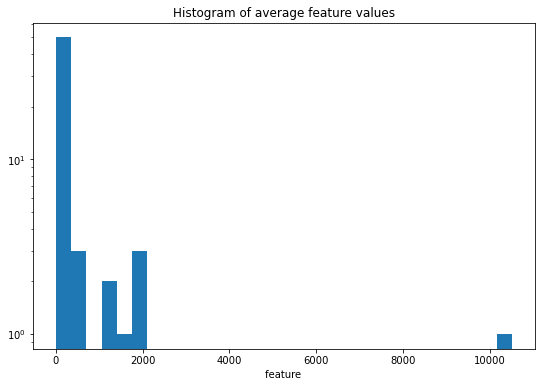

ratio of maximum to minimum average feature value: 1.8e+05


In [7]:
X = np.array(train[features].values, np.float)

plt.figure(figsize=(9, 6))
plt.title("Histogram of average feature values")
plt.hist(np.mean(X, 0), bins=30)
plt.yscale("log")
plt.xlabel("feature ")
plt.show()

ratio = np.max(np.mean(X, 0))/np.min(np.mean(X, 0))
print("ratio of maximum to minimum average feature value: {:.1e}".format(ratio))

Features exist on a hugely different scale, with 'LotArea' and 'Utilities' varying over 7 orders of magnitude

In [8]:
print("features sorted from low to high, \n", np.array(features)[np.argsort(np.mean(X, 0))])

features sorted from low to high, 
 ['BsmtHalfBath' 'LandSlope' 'HalfBath' 'BsmtFullBath' 'LotShape'
 'Fireplaces' 'LotConfig' 'CentralAir' 'Street' 'Utilities' 'KitchenAbvGr'
 'LandContour' 'ExterQual' 'KitchenQual' 'FullBath' 'RoofStyle'
 'GarageCars' 'PavedDrive' 'RoofMatl' 'MSZoning' 'PoolArea' 'ExterCond'
 'BedroomAbvGr' 'HeatingQC' 'Foundation' '3SsnPorch' 'BldgType'
 'Condition1' 'SaleCondition' 'Condition2' 'SaleType' 'HouseStyle'
 'Heating' 'OverallCond' 'Functional' 'LowQualFinSF' 'OverallQual'
 'MoSold' 'TotRmsAbvGrd' 'Exterior1st' 'Exterior2nd' 'Neighborhood'
 'ScreenPorch' 'EnclosedPorch' 'MiscVal' 'BsmtFinSF2' 'OpenPorchSF'
 'MSSubClass' 'WoodDeckSF' '2ndFlrSF' 'BsmtFinSF1' 'GarageArea'
 'BsmtUnfSF' 'TotalBsmtSF' '1stFlrSF' 'GrLivArea' 'YearBuilt'
 'YearRemodAdd' 'YrSold' 'LotArea']


In [9]:
# take decades since 2020 for features that describe the year 
yearfeatures = [f for f in features if 'Year' in f or 'Yr' in f]
train[yearfeatures] = (2020 - train[yearfeatures].values)/ 10

In [10]:
# take square root of features that describe area and divide by max 
areafeatures = [f for f in features if 'SF' in f or 'Area' in f]
train[areafeatures] = train[areafeatures].values**.5 / np.max(train[areafeatures].values**.5, 0)

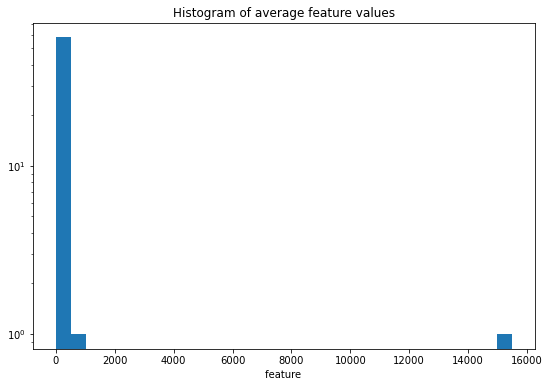

ratio of maximum to minimum average feature value: 1.3e+04


In [11]:
X = np.array(train[features].values, np.float)

plt.figure(figsize=(9, 6))
plt.title("Histogram of average feature values")
plt.hist(np.max(X, 0), bins=30)
plt.yscale("log")
plt.xlabel("feature ")
plt.show()

ratio = np.max(np.mean(X, 0))/np.min(np.mean(X, 0))
print("ratio of maximum to minimum average feature value: {:.1e}".format(ratio))

In [12]:
print("features sorted from low to high, \n", np.array(features)[np.argsort(np.max(X, 0))])

features sorted from low to high, 
 ['PoolArea' 'Street' 'OpenPorchSF' 'WoodDeckSF' 'GarageArea' 'GrLivArea'
 'LowQualFinSF' '2ndFlrSF' '1stFlrSF' 'Utilities' 'BsmtUnfSF' 'LotArea'
 'TotalBsmtSF' 'CentralAir' 'BsmtFinSF2' 'BsmtFinSF1' 'YrSold'
 'PavedDrive' 'BsmtHalfBath' 'HalfBath' 'LandSlope' 'LotShape' 'ExterQual'
 'KitchenQual' 'BsmtFullBath' 'Fireplaces' 'KitchenAbvGr' 'LandContour'
 'FullBath' 'HeatingQC' 'ExterCond' 'BldgType' 'LotConfig' 'MSZoning'
 'GarageCars' 'RoofStyle' 'Foundation' 'Heating' 'SaleCondition'
 'Functional' 'YearRemodAdd' 'Condition2' 'HouseStyle' 'RoofMatl'
 'Condition1' 'SaleType' 'BedroomAbvGr' 'OverallCond' 'OverallQual'
 'MoSold' 'TotRmsAbvGrd' 'Exterior1st' 'YearBuilt' 'Exterior2nd'
 'Neighborhood' 'MSSubClass' 'ScreenPorch' '3SsnPorch' 'EnclosedPorch'
 'MiscVal']


In [13]:
# set up training data 
X = np.array(train[features].values, np.float)
y = np.array(train[target].values, np.float)

# center data 
X = MinMaxScaler((-1, 1)).fit(X).transform(X)

# actually predict centered log_y 
y = np.log(y) - np.mean(np.log(y)) 

In [14]:
def HyperParamOpt1D(X, y, classifier, hyperparams, n_splits):
    # init list of oof prediction performances 
    oof_performance = []
    
    # loop over hyperparameters 
    for hyperparam in hyperparams:
        # set up out of fold 
        oof = np.zeros(X.shape[0])
        
        # pull each subset for training 
        skf = KFold(n_splits, shuffle=True)
        skf.get_n_splits(X, y)
        for train_index, val_index in skf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            # init classifier 
            clf = classifier(alpha=hyperparam)
            clf.fit(X_train, y_train)
            # make predictions 
            oof[val_index] = clf.predict(X_val).flatten()
            
        # calculate mse 
        #mse = np.linalg.norm(oof - y)
        R2score = -R2(oof, y)
        oof_performance.append(R2score)
    
    # choose best weights from validation performance 
    best_param = hyperparams[np.argmin(oof_performance)]
    
    # fit best model 
    best_clf = classifier(alpha=best_param)
    best_clf.fit(X, y)
    
    return best_clf, best_param 

In [15]:
# set hyperparams to optimize over 
hyperparams = np.logspace(-4, np.log10(20), 20)

# record out-of-fold predictions for Lasso and Ridge regression
oof_L = np.zeros(X.shape[0])
oof_R = np.zeros(X.shape[0])

# split data into 10 train+validation and testing data sets
skf1 = KFold(n_splits=10, shuffle=True, random_state=123)
skf1.get_n_splits(X, y)
for trainval_index, test_index in tqdm(skf1.split(X), desc="K-Fold"):
    # split the whole dataset into training+validation data and testing sets
    X_trainval, X_test = X[trainval_index], X[test_index]
    y_trainval, y_test = y[trainval_index], y[test_index]
    
    ### RIDGE ###
    # see what hyperparameter performs best on validation data 
    best_model, best_param = HyperParamOpt1D(X_trainval, y_trainval, Ridge, hyperparams, n_splits=9)
    
    # make predictions 
    y_pred_test = best_model.predict(X_test)
    
    # store predictions
    oof_R[test_index] = y_pred_test.flatten()
    
    ### LASSO ###
    # see what hyperparameter performs best on validation data 
    best_model, best_param = HyperParamOpt1D(X_trainval, y_trainval, Lasso, hyperparams, n_splits=9)
    
    # make predictions 
    y_pred_test = best_model.predict(X_test)
    
    # store predictions
    oof_L[test_index] = y_pred_test.flatten()

K-Fold: 10it [00:11,  1.17s/it]


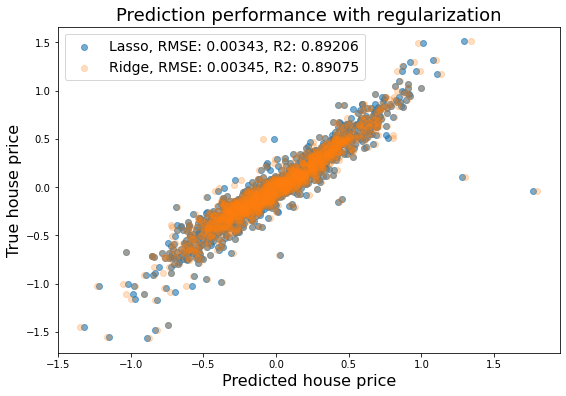

In [26]:
# calculate performance
rmse_ridge = np.linalg.norm(y.ravel() - oof_R)/len(y)
rmse_lasso = np.linalg.norm(y.ravel() - oof_L)/len(y)
R2_ridge  = R2(y, oof_R)
R2_lasso  = R2(y, oof_L)

plt.figure(figsize=(9, 6))

plt.scatter(oof_L, y, alpha=.6, label="Lasso, RMSE: {:.5f}, R2: {:.5f}".format(rmse_lasso, R2_lasso))
plt.scatter(oof_R, y, alpha=.25, label="Ridge, RMSE: {:.5f}, R2: {:.5f}".format(rmse_ridge, R2_ridge))
plt.xlabel("Predicted house price", fontsize=16)
plt.ylabel("True house price", fontsize=16)

plt.legend(fontsize=14)
plt.title("Prediction performance with regularization", fontsize=18)
plt.show()